# Predict the number of actual attendees of colts games based on a variety of factors
# This includes ticket sales from the past 2 seasons. Predict which games will and will not be attended
- Note, some of the lines of code may look inefficient because there is only so much memory on my computer and I have to find a different way

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
import sklearn
import datetime
from datetime import date
from datetime import datetime
import math

In [2]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklego.preprocessing import RepeatingBasisFunction



In [3]:
tickets = pd.read_csv("../updated_datasets/Cross Road Analytics Competition Dataset.csv")
extra_predictors = pd.read_csv("../updated_datasets/predictors_extra.csv")
tickets_test = pd.read_csv("../updated_datasets/test.csv")

/var/folders/mh/9fr225sj6bd0qgb1553s86dw0000gn/T/ipykernel_45288/1686313897.py:1: DtypeWarning: Columns (0,30) have mixed types. Specify dtype option on import or set low_memory=False.
  tickets = pd.read_csv("../updated_datasets/Cross Road Analytics Competition Dataset.csv")
/var/folders/mh/9fr225sj6bd0qgb1553s86dw0000gn/T/ipykernel_45288/1686313897.py:3: DtypeWarning: Columns (0,29) have mixed types. Specify dtype option on import or set low_memory=False.
  tickets_test = pd.read_csv("../updated_datasets/test.csv")


In [4]:
def to_the_proper_date(bad_date):
    # Converting to datetime object, then converting to string with the format I want
    return datetime.strptime(bad_date, '%m/%d/%y').strftime("%Y-%m-%d")


tickets_test['event_date'] =tickets_test['event_date'].apply(to_the_proper_date)

In [5]:
tickets = pd.concat([tickets, tickets_test])

### Fixing up the extra_predictors

In [8]:
extra_predictors.head()

,Unnamed: 0,Date,Coach,Weather,Division,Roof_open,Themed_games,Holiday,Holiday_five_days,Time_of_day,day_of_week,sunday,merch_give_away,events (Y/N)
0,1,2021-08-15,Reich,Sunny,Div_N,Open,Theme_Yes,Hol_No,Hol_five_No,1:00 PM,Sunday,Sun_Yes,Merch_No,other_events_Yes
1,2,2021-09-12,Reich,Sunny,Div_N,Closed,Theme_Yes,Hol_No,Hol_five_No,1:00 PM,Sunday,Sun_Yes,Merch_No,other_events_No
2,3,2021-09-19,Reich,Sunny,Div_N,Closed,Theme_Yes,Hol_No,Hol_five_No,1:00 PM,Sunday,Sun_Yes,Merch_No,other_events_No
3,4,2021-10-17,Reich,Sunny,Div_Y,Open,Theme_Yes,Hol_No,Hol_five_No,1:00 PM,Sunday,Sun_Yes,Mercch_Yes,other_events_No
4,5,2021-10-31,Reich,Sunny,Div_Y,Open,Theme_Yes,Hol_No,Hol_five_Yes,1:00 PM,Sunday,Sun_Yes,Mercch_Yes,other_events_Yes


In [6]:
extra_predictors['Date'] = pd.to_datetime(extra_predictors['Date'], infer_datetime_format=True)

In [7]:
def format_date(datetime):
    return datetime.strftime("%Y-%m-%d")

extra_predictors['Date'] = extra_predictors['Date'].apply(format_date)

extra_predictors.head()

,Unnamed: 0,Date,Coach,Weather,Division,Roof_open,Themed_games,Holiday,Holiday_five_days,Time_of_day,day_of_week,sunday,merch_give_away,events (Y/N)
0,1,2021-08-15,Reich,Sunny,Div_N,Open,Theme_Yes,Hol_No,Hol_five_No,1:00 PM,Sunday,Sun_Yes,Merch_No,other_events_Yes
1,2,2021-09-12,Reich,Sunny,Div_N,Closed,Theme_Yes,Hol_No,Hol_five_No,1:00 PM,Sunday,Sun_Yes,Merch_No,other_events_No
2,3,2021-09-19,Reich,Sunny,Div_N,Closed,Theme_Yes,Hol_No,Hol_five_No,1:00 PM,Sunday,Sun_Yes,Merch_No,other_events_No
3,4,2021-10-17,Reich,Sunny,Div_Y,Open,Theme_Yes,Hol_No,Hol_five_No,1:00 PM,Sunday,Sun_Yes,Mercch_Yes,other_events_No
4,5,2021-10-31,Reich,Sunny,Div_Y,Open,Theme_Yes,Hol_No,Hol_five_Yes,1:00 PM,Sunday,Sun_Yes,Mercch_Yes,other_events_Yes


In [8]:
extra_predictors['merch_give_away'] = extra_predictors.merch_give_away.replace(np.nan,"No")

In [9]:
extra_encoder_list = ['Coach','Weather','Division', 'Roof_open','Themed_games','Holiday','Holiday_five_days','day_of_week','sunday','merch_give_away','events (Y/N)']

encoder_extra = OneHotEncoder(sparse=  False)
encoder_extra.fit(extra_predictors[extra_encoder_list])
one_hot_encoded_extra_np = encoder_extra.transform(extra_predictors[extra_encoder_list])

out_extra = np.concatenate(encoder_extra.categories_).ravel().tolist()
one_hot_encoded_extra_pd = pd.DataFrame(one_hot_encoded_extra_np, columns = out_extra)

In [10]:
one_hot_encoded_extra_cols = one_hot_encoded_extra_pd.columns

In [11]:
one_hot_encoded_extra_pd['event_date'] = extra_predictors['Date']

In [14]:
one_hot_encoded_extra_pd.head()

,Reich,Saturday,Cloudy,Sunny,Div_N,Div_Y,Closed,Open,Theme_Yes,Hol_No,...,Sunday,Sunday,Thursday,Sun_No,Sun_Yes,Mercch_Yes,Merch_No,other_events_No,other_events_Yes,event_date
0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,2021-08-15
1,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,2021-09-12
2,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,2021-09-19
3,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,2021-10-17
4,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,2021-10-31


### Looking at the data...

In [15]:
tickets.head()

,acct_id,acct_type_desc,event_name,event_date,plan_event_name,comp_name,section_name,row_name,SeatNum,price_code,...,SeatUniqueID,Season,ClubExpYear,Tenure,UniqueID,isAttended,Resold,ResalePrice,ResaleDate,isSTM
0,117948790,Season,CLT21HOU,2021-10-17,21FS,Not Comp,101,10,1,FR,...,101-10-1,2021,NaN,25.0,CLT21HOU-101-10-1,Yes,NaN,NaN,NaN,NaN
1,126665090,Season,CLT21HOU,2021-10-17,21FS,Not Comp,101,10,10,FR,...,101-10-10,2021,NaN,20.0,CLT21HOU-101-10-10,No,NaN,NaN,NaN,NaN
2,126665090,Season,CLT21HOU,2021-10-17,21FS,Not Comp,101,10,11,FR,...,101-10-11,2021,NaN,20.0,CLT21HOU-101-10-11,No,NaN,NaN,NaN,NaN
3,1489599590,Season,CLT21HOU,2021-10-17,21FS,Not Comp,101,10,12,FR,...,101-10-12,2021,NaN,4.0,CLT21HOU-101-10-12,Yes,NaN,NaN,NaN,NaN
4,115101990,Season,CLT21HOU,2021-10-17,21FS,Not Comp,101,10,13,FR,...,101-10-13,2021,NaN,32.0,CLT21HOU-101-10-13,No,NaN,NaN,NaN,NaN


### Must get the team name and split it apart; we do not need the entire column of event_name

In [12]:
def extract_second(s):
    if "21" in s:
        return s.split("21")[1]
    elif "22" in s:
        return s.split("22")[1]
    elif "23" in s:
        return s.split("23")[1]

tickets["opponent"] = tickets["event_name"].apply(extract_second)

### Must encode the event date; This is done by using the radial basis function; we will have to re-add this data at the end

In [13]:
tickets_dates = tickets[['event_date']]

def get_the_day(dateyear):
    date = datetime.strptime(dateyear, "%Y-%m-%d")
    return date.timetuple().tm_yday

tickets_dates['day_of_year'] = tickets_dates['event_date'].apply(get_the_day)


rbf = RepeatingBasisFunction(n_periods=12,
                         	column="day_of_year",
                         	input_range=(1,365),
                         	remainder="drop")


rbf.fit(tickets_dates)
tickets_dates_tranformed = pd.DataFrame(index=tickets_dates.event_date,
               	data=rbf.transform(tickets_dates))

#tickets_dates_tranformed['event_date'] = tickets_dates_tranformed.index		

/var/folders/mh/9fr225sj6bd0qgb1553s86dw0000gn/T/ipykernel_45288/1549609834.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tickets_dates['day_of_year'] = tickets_dates['event_date'].apply(get_the_day)


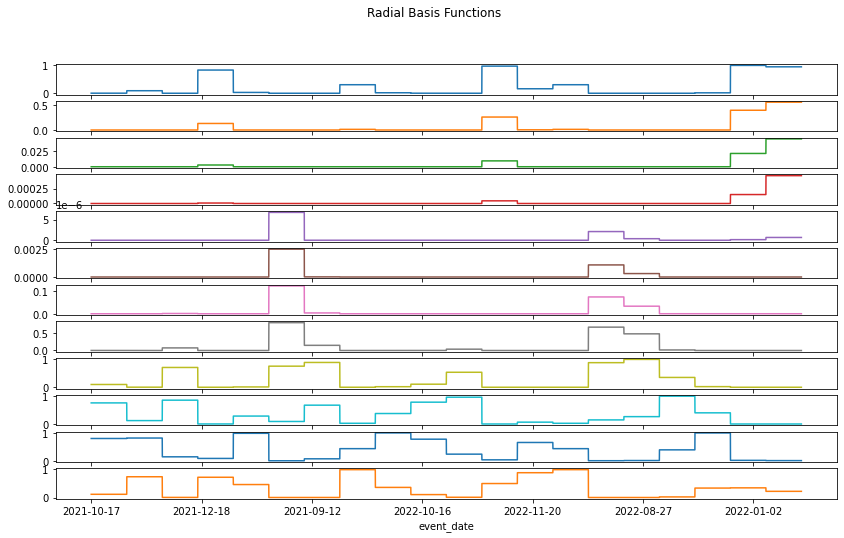

In [20]:
tickets_dates_tranformed.plot(subplots=True, figsize=(14, 8),
     	sharex=True, title="Radial Basis Functions",
     	legend=False);

### Merging the event date here

In [14]:
#tickets = tickets.merge(tickets_dates_tranformed, on= 'event_date')

tickets[["event_date_0","event_date_1","event_date_2","event_date_3","event_date_4","event_date_5","event_date_6","event_date_7","event_date_8","event_date_9","event_date_10","event_date_11"]] = tickets_dates_tranformed.to_numpy()

In [20]:
tickets.head()

,acct_id,acct_type_desc,event_name,event_date,plan_event_name,comp_name,section_name,row_name,SeatNum,price_code,...,event_date_2,event_date_3,event_date_4,event_date_5,event_date_6,event_date_7,event_date_8,event_date_9,event_date_10,event_date_11
0,117948790,Season,CLT21HOU,2021-10-17,21FS,Not Comp,101,10,1,FR,...,2.053948e-09,9.851605e-14,5.382962e-14,1.252646e-09,0.000004,0.001681,0.096988,0.757125,0.799889,0.114368
1,126665090,Season,CLT21HOU,2021-10-17,21FS,Not Comp,101,10,10,FR,...,2.053948e-09,9.851605e-14,5.382962e-14,1.252646e-09,0.000004,0.001681,0.096988,0.757125,0.799889,0.114368
2,126665090,Season,CLT21HOU,2021-10-17,21FS,Not Comp,101,10,11,FR,...,2.053948e-09,9.851605e-14,5.382962e-14,1.252646e-09,0.000004,0.001681,0.096988,0.757125,0.799889,0.114368
3,1489599590,Season,CLT21HOU,2021-10-17,21FS,Not Comp,101,10,12,FR,...,2.053948e-09,9.851605e-14,5.382962e-14,1.252646e-09,0.000004,0.001681,0.096988,0.757125,0.799889,0.114368
4,115101990,Season,CLT21HOU,2021-10-17,21FS,Not Comp,101,10,13,FR,...,2.053948e-09,9.851605e-14,5.382962e-14,1.252646e-09,0.000004,0.001681,0.096988,0.757125,0.799889,0.114368


### Must encode the add date
- Some ticket were not added, therefore, must make a yes/no column to supplement this

In [15]:
def ticket_added(ticket_date_add):
    if (ticket_date_add == 'NaN'):
        return "No"
    else:
        return "Yes"
        
tickets["ticket_added"] = tickets["add_datetime"].apply(ticket_added)

In [16]:
tickets = pd.merge(tickets, one_hot_encoded_extra_pd, on= 'event_date')

### Dropping labels

In [17]:
tickets = tickets.drop(labels =['acct_id', 'Start Year', 'LastYear','event_date','ResalePrice','ResaleDate', 'add_datetime'], axis = 1)

In [24]:
tickets.head()

,acct_type_desc,event_name,plan_event_name,comp_name,section_name,row_name,SeatNum,price_code,PC1,Price,...,Saturday,Sunday,Sunday,Thursday,Sun_No,Sun_Yes,Mercch_Yes,Merch_No,other_events_No,other_events_Yes
0,Season,CLT21HOU,21FS,Not Comp,101,10,1,FR,F,111.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
1,Season,CLT21HOU,21FS,Not Comp,101,10,10,FR,F,111.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
2,Season,CLT21HOU,21FS,Not Comp,101,10,11,FR,F,111.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
3,Season,CLT21HOU,21FS,Not Comp,101,10,12,FR,F,111.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
4,Season,CLT21HOU,21FS,Not Comp,101,10,13,FR,F,111.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0


In [25]:
tickets.shape

(1286916, 64)

In [26]:
tickets.isnull().sum()

acct_type_desc       91418
event_name               0
plan_event_name     279172
comp_name            80644
section_name             0
                     ...  
Sun_Yes                  0
Mercch_Yes               0
Merch_No                 0
other_events_No          0
other_events_Yes         0
Length: 64, dtype: int64

### Deterimining which variables are categorical
- Should seat/section/row numbers be categorical since this is technically a location and not a number.

In [27]:
categorical = [var for var in tickets.columns if tickets[var].dtype=='O']
print('There are {} categorical variables\n'.format(len(categorical)))
print('The categorical variables are :\n\n', categorical)

AttributeError: 'DataFrame' object has no attribute 'dtype'

- Getting which categorical data are null

In [ ]:
tickets[categorical].isnull().sum()

- Checking the frequency of the categorical variables

In [ ]:
categorical = [var for var in tickets.columns if tickets[var].dtype=='O']
for var in categorical: 
    print(tickets[var].value_counts()/np.float(len(tickets)))

- Looking at the cardinality of the dataset

In [21]:
for var in categorical:
    print(var, ' contains ', len(tickets[var].unique()), ' labels')

acct_type_desc  contains  31  labels
event_name  contains  20  labels
event_date  contains  20  labels
plan_event_name  contains  8  labels
comp_name  contains  23  labels
row_name  contains  67  labels
price_code  contains  1189  labels
PC1  contains  31  labels
paid  contains  4  labels
add_datetime  contains  68992  labels
class_name  contains  48  labels
status  contains  4  labels
SeatType  contains  2  labels
TicketClass  contains  6  labels
TicketType  contains  26  labels
SeatUniqueID  contains  64346  labels
UniqueID  contains  1286916  labels
isAttended  contains  3  labels
Resold  contains  4  labels
ResaleDate  contains  20743  labels


### Interpolating the time series data
- Note: Term = Start year - Last year
    - This means its only necessary to interpolate the Term; Does term only apply to season ticket holders or people of that nature

### To encode or not to encode
- acct_type: Categorical
- event name: Should we even keep this??? What if the game is new... this would be making a new categorical variable. What are we predicting off of? If all of the variables remain the same, it would be wise to only encode the team name who they are playing. 
- event_date: Time-series data (does not have seconds). Possible eliminate the year; time in month may be more important
- plan_event_name: Categorical
- comp_name: Categorical
- LOCATION
    - section: Categorical
    - row_name: Categorical or Numerical? Numerical since this is similar to a rank?
    - SeatNum: Categorical or Numerical? Numerical since this is similar to a rank?
- price_code: Categorical
- PC1: Categorical
- Price: Numerical
- Paid: Categorical
- add_datetime: Time-series data (does not have seconds). There is some missing data here. May have to do time series interpolation
- class_name: Categorical
- status: Categorical
- Sales_Source: encode as true or false
- isHost: Categorical; Already encoded
- SeatType: Categorical (only 2 classes)
- TicketClass: Categorical
- Term: Code as 0 if Na... this will be ordinal data
- TicketType: Categorical
- SeatUniqueID: Categorical or Numerical? Its a unique one
- Season: Ordinal; But would we need to include this because we are predicting future data. Next season, there would be nothing to predict off of in this class. 
- ClubExpYear: Includes NA, therefore must encode this as ordinal
- Tenure: Has missing data and 0's. What should we encode NA as? Should be able to encode this as ordinal data
- UniqueID: Has the event_name + SeatUnique
- isAttended: Categorical (yes or no)
- Resold: Has NA, 1.0, '1' and 'Yes'; we must encode the 1's as 1 and NA as 0
- ResaleDate: Delete this column. Likely does not matter. 
- isSTM: 1 is 'yes', nan is 'no'; Must categorically encode this



###  Encoding what can be encoded as categorical...
- acct_type
- plan_event_name
- comp_name
- price_code
- Paid
- class_name
- status
- TicketClass
- TicketType
- Sales_Source
- SeatType
- IsAttended (must be label encoded)
- Resold
- isSTM

#### Label encoding isAttended

In [18]:
label_enc = LabelEncoder()
isAttended_label = tickets[['isAttended']]
label_enc.fit(isAttended_label)
tickets['isAttended'] = label_enc.transform(isAttended_label)

/Users/caiden/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


#### Adjusting data that has Na etc...

In [19]:
tickets[['Resold', 'isSTM','Sales_Source','Term','Tenure']] = tickets[['Resold', 'isSTM','Sales_Source','Term','Tenure']].replace(np.nan,0)

In [20]:
tickets[['Resold']] =  tickets[['Resold']].replace('Yes', 1)
tickets[['Resold']] =  tickets[['Resold']].replace('1', 1)
tickets[['paid']] = tickets[['paid']].replace(np.nan, 'paid_unknown')
tickets[['acct_type_desc']] = tickets[['acct_type_desc']].replace(np.nan, 'acct_desc_unknown')
tickets[['comp_name']] = tickets[['comp_name']].replace(np.nan, 'comp_name_unknown')
tickets[['plan_event_name']] = tickets[['plan_event_name']].replace(np.nan, 'plan_event_name_unknown')
tickets[['ClubExpYear']] = tickets[['ClubExpYear']].replace(np.nan, 'exp_year_unknown')
tickets[["Season"]] = tickets[['Season']].replace(2021, "season_2021")
tickets[["Season"]] = tickets[['Season']].replace(2022, "season_2022")

In [27]:
tickets.isnull().sum()

acct_type_desc      0
event_name          0
plan_event_name     0
comp_name           0
section_name        0
                   ..
Sun_Yes             0
Mercch_Yes          0
Merch_No            0
other_events_No     0
other_events_Yes    0
Length: 64, dtype: int64

#### Getting the dummiess for the rest

In [21]:
categorical_encoding_list = ['acct_type_desc','plan_event_name','comp_name','price_code','paid','class_name','status','TicketClass','TicketType','SeatType', 'Sales_Source','opponent' ,'section_name', 'row_name','SeatNum', 'ticket_added', 'ClubExpYear', 'Season', 'PC1']
categorical_one_zero = ['isHost','isSTM','Resold']


In [22]:
tickets[categorical_encoding_list] = tickets[categorical_encoding_list].astype(str)

In [23]:
encoder = OneHotEncoder(sparse=  False)
encoder.fit(tickets[categorical_encoding_list])
one_hot_encoded_categorical_np = encoder.transform(tickets[categorical_encoding_list])

out = np.concatenate(encoder.categories_).ravel().tolist()
one_hot_encoded_categorical_pd = pd.DataFrame(one_hot_encoded_categorical_np, columns = out)

In [24]:
one_hot_encoded_categorical_pd[categorical_one_zero] = tickets[categorical_one_zero]

In [ ]:
#one_hot_encoded_categorical_pd[one_hot_encoded_extra_cols] = one_hot_encoded_extra_pd

In [25]:
tickets = tickets.drop(labels =categorical_encoding_list, axis = 1)
tickets = tickets.drop(labels =categorical_one_zero, axis = 1)

In [37]:
tickets.head()

,event_name,Price,Term,SeatUniqueID,Tenure,UniqueID,isAttended,event_date_0,event_date_1,event_date_2,...,Saturday,Sunday,Sunday,Thursday,Sun_No,Sun_Yes,Mercch_Yes,Merch_No,other_events_No,other_events_Yes
0,CLT21HOU,111.0,0.0,101-10-1,25.0,CLT21HOU-101-10-1,1,0.002213,0.000006,2.053948e-09,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
1,CLT21HOU,111.0,0.0,101-10-10,20.0,CLT21HOU-101-10-10,0,0.002213,0.000006,2.053948e-09,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
2,CLT21HOU,111.0,0.0,101-10-11,20.0,CLT21HOU-101-10-11,0,0.002213,0.000006,2.053948e-09,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
3,CLT21HOU,111.0,0.0,101-10-12,4.0,CLT21HOU-101-10-12,1,0.002213,0.000006,2.053948e-09,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
4,CLT21HOU,111.0,0.0,101-10-13,32.0,CLT21HOU-101-10-13,0,0.002213,0.000006,2.053948e-09,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0


In [15]:
#undo_onehot = encoder.inverse_transform(one_hot_encoded_categorical_np)
#undo_onehot = pd.DataFrame(undo_onehot, columns = out)

###  Encoding what can be encoded as ordinal...
- Term
    - Since in order, do not have to encode

###  Encoding what can be encoded as numerical...
- Price
    - We will inclide all prices. We will not eliminate outliers due to varying ticket prices
    - Must (briefly) make the train and test sets to ensure that the new data is scaled on old data

In [26]:
price_scaler = StandardScaler()
price_scaler.fit(tickets[['Price']])
tickets['Price'] = price_scaler.transform(tickets[['Price']])

In [27]:
tickets_bare = tickets.copy()

In [28]:
tickets_bare.head()
bare_cols =tickets_bare.columns

In [29]:
tickets_cleaned = one_hot_encoded_categorical_pd.copy()


In [ ]:
#tickets_cleaned[bare_cols] = tickets_bare.to_numpy()

In [30]:
tickets_cleaned = pd.concat([tickets_cleaned, tickets_bare],axis=1)

In [43]:
tickets_cleaned.head()

,Club,Comp,Employee,Group,Group NEW,Hold,Hold Account,House,Huntington,Huntington 2014,...,Saturday,Sunday,Sunday,Thursday,Sun_No,Sun_Yes,Mercch_Yes,Merch_No,other_events_No,other_events_Yes
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0


### Getting each of the games partially, then putting them together to do a smaller test

In [ ]:
#tickets_bare_partial = tickets_bare.sample(frac = 0.05, replace = False ,random_state= 1234)
#tickets_cleaned_partial = tickets_cleaned.sample(frac = 0.05,replace = False ,random_state= 1234)

In [ ]:
#tickets_bare_partial.to_csv("../ticket_bare_partial.csv")
#tickets_cleaned_partial.to_csv("../ticket_cleaned_partial.csv")

In [ ]:
#tickets_cleaned.to_csv("../tickets_cleaned_full.csv")

In [ ]:
#tickets_bare.to_csv("../tickets_bare_full.csv")

In [ ]:
#tickets_train = tickets[(tickets['event_name'] != 'CLT22HOU') & (tickets['event_name'] != 'CLT21LV')]
#tickets_test = tickets[(tickets['event_name'] == 'CLT22HOU') | (tickets['event_name'] == 'CLT21LV')]
#tickets = tickets.drop(labels=['SeatUniqueID', 'event_name'])

In [31]:
test = tickets_cleaned[(tickets_cleaned['event_name'] == 'CLT21LV') | (tickets_cleaned['event_name'] == 'CLT22HOU')]
train = tickets_cleaned[(tickets_cleaned['event_name'] != 'CLT21LV') & (tickets_cleaned['event_name'] != 'CLT22HOU')]

In [39]:
del tickets_cleaned
del tickets_bare
del tickets
del encoder
del one_hot_encoded_categorical_np
del one_hot_encoded_categorical_pd
del LabelEncoder
del extra_predictors

In [40]:
test_UniqueID = test[['UniqueID']]
train_UniqueID = train[['UniqueID']]

In [35]:
y_train = train[['isAttended','UniqueID','event_name']]
y_test = test[['isAttended','UniqueID','event_name']]

In [43]:
test_labels = test[['event_name','UniqueID']]
train_labels = train[['event_name','UniqueID']]

In [43]:
test_labels.to_csv("../PCA_data/test_labels.csv")
train_labels.to_csv("../PCA_data/train_label.csv")

In [35]:
y_train['UniqueID'] = train_UniqueID['UniqueID']

/var/folders/mh/9fr225sj6bd0qgb1553s86dw0000gn/T/ipykernel_6349/3334995957.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train['UniqueID'] = train_UniqueID['UniqueID']


In [37]:
y_test = test_UniqueID['UniqueID']

In [65]:
test_UniqueID[['UniqueID']]

,UniqueID
1158228,CLT21LV-101-10-1
1158229,CLT21LV-101-10-10
1158230,CLT21LV-101-10-11
1158231,CLT21LV-101-10-12
1158232,CLT21LV-101-10-13
...,...
1286911,CLT22HOU-646-9-5
1286912,CLT22HOU-646-9-6
1286913,CLT22HOU-646-9-7
1286914,CLT22HOU-646-9-8


In [36]:
y_train.head()

,isAttended,UniqueID
0,1,CLT21HOU-101-10-1
1,0,CLT21HOU-101-10-10
2,0,CLT21HOU-101-10-11
3,1,CLT21HOU-101-10-12
4,0,CLT21HOU-101-10-13


In [36]:
y_train.to_csv("../PCA_data/y_train2.csv")
y_test.to_csv("../PCA_data/y_test2.csv")

# Disregard this code

In [16]:
tickets.Sales_Source.unique()

array([0.0000e+00, 1.0431e+04, 9.4900e+03, 9.4540e+03, 1.0432e+04,
       5.7780e+03, 1.0430e+04, 1.0450e+04, 1.0428e+04, 1.0433e+04,
       1.0444e+04, 5.4830e+03, 1.0449e+04, 5.9430e+03, 1.0437e+04,
       4.4450e+03, 1.0434e+04, 8.6670e+03, 1.0383e+04, 1.0426e+04,
       4.2420e+03, 1.0470e+04, 4.1530e+03, 4.3600e+03, 5.7840e+03,
       1.0446e+04, 1.0447e+04, 1.0436e+04, 1.0440e+04, 1.0454e+04,
       1.0455e+04, 5.3590e+03, 1.0142e+04, 1.0468e+04, 1.0439e+04,
       1.0438e+04, 1.0445e+04, 1.0453e+04, 1.0451e+04, 4.9580e+03,
       1.0435e+04, 4.3260e+03, 1.0441e+04, 1.0452e+04, 4.4060e+03,
       9.0000e+00, 1.0376e+04, 1.0475e+04, 1.0472e+04, 4.3490e+03,
       1.0474e+04, 1.0479e+04, 1.0478e+04, 1.0580e+04, 1.0473e+04,
       1.0476e+04, 1.0471e+04, 1.0482e+04, 1.0480e+04, 1.0481e+04,
       1.0508e+04, 1.0483e+04, 1.0509e+04, 3.7220e+03, 1.0477e+04,
       6.6500e+02, 1.0507e+04, 1.0191e+04, 4.6160e+03, 9.3740e+03,
       3.5290e+03, 1.0589e+04, 1.0484e+04, 2.7590e+03, 1.0501e

In [36]:
tickets.section_name.unique()

array([101, 102, 103, 105, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 121, 124, 125, 126, 127, 128, 129, 132, 135, 136, 137,
       138, 139, 140, 141, 142, 143, 144, 145, 148, 151, 152, 153, 204,
       205, 206, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218,
       220, 221, 222, 223, 224, 225, 227, 228, 229, 230, 231, 232, 233,
       235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 247, 248,
       249, 303, 304, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315,
       316, 317, 318, 319, 320, 322, 323, 324, 325, 326, 327, 328, 329,
       330, 331, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343,
       344, 345, 346, 347, 349, 350, 401, 402, 403, 404, 406, 407, 408,
       409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 422,
       423, 424, 425, 427, 428, 429, 430, 431, 433, 434, 435, 436, 437,
       438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 449, 450, 451,
       452, 453, 504, 506, 507, 508, 509, 510, 511, 512, 513, 51

In [33]:
tickets[tickets['event_name'] == 'CLT22HOU'].isAttended.unique()
tickets[tickets['event_name'] == 'CLT21LV'].isAttended.unique()


array([0])

In [16]:
undo_onehot

array([['Season', '21FS', 'Not Comp', ..., 0.0, 0.0, 0.0],
       ['Season', '21FS', 'Not Comp', ..., 0.0, 0.0, 0.0],
       ['Season', '21FS', 'Not Comp', ..., 0.0, 0.0, 0.0],
       ...,
       ['Sponsor', '22FS8', 'Not Comp', ..., 0.0, 0.0, 0.0],
       ['Sponsor', '22FS8', 'Not Comp', ..., 0.0, 0.0, 0.0],
       ['Sponsor', '22FS8', 'Not Comp', ..., 0.0, 0.0, 0.0]], dtype=object)

In [40]:
example = tickets['event_name'].str.split(pat= "CLT", expand=True)


In [ ]:
def extract_second(s):
    if "21" in s:
        return s.split("21")[1]
    elif "22" in s:
        return s.split("22")[1]

tickets["result"] = tickets["string"].apply(extract_second)

In [41]:
example[1] = example[1].str.split(pat = '21', expand= True)

ValueError: Columns must be same length as key

In [26]:
tickets_dates = tickets[['event_date']]
#tickets_dates["day_nr"] = range(len(tickets['event_date']))

def get_the_day(dateyear):
    date = datetime.strptime(dateyear, "%Y-%m-%d")
    return date.timetuple().tm_yday

tickets_dates['day_of_year'] = tickets_dates['event_date'].apply(get_the_day)


/var/folders/mh/9fr225sj6bd0qgb1553s86dw0000gn/T/ipykernel_21757/2111562690.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tickets_dates['day_of_year'] = tickets_dates['event_date'].apply(get_the_day)


In [28]:
rbf = RepeatingBasisFunction(n_periods=12,
                         	column="day_of_year",
                         	input_range=(1,365),
                         	remainder="drop")

In [33]:
rbf.fit(tickets_dates)
tickets_dates_tranformed = pd.DataFrame(index=tickets_dates.event_date,
               	data=rbf.transform(tickets_dates))



In [34]:
tickets_dates_tranformed

,0,1,2,3,4,5,6,7,8,9,10,11
event_date,,,,,,,,,,,,
2021-10-17,0.002213,0.000006,2.053948e-09,9.851605e-14,5.382962e-14,1.252646e-09,3.944997e-06,0.001681,0.096988,0.757125,0.799889,0.114368
2021-10-17,0.002213,0.000006,2.053948e-09,9.851605e-14,5.382962e-14,1.252646e-09,3.944997e-06,0.001681,0.096988,0.757125,0.799889,0.114368
2021-10-17,0.002213,0.000006,2.053948e-09,9.851605e-14,5.382962e-14,1.252646e-09,3.944997e-06,0.001681,0.096988,0.757125,0.799889,0.114368
2021-10-17,0.002213,0.000006,2.053948e-09,9.851605e-14,5.382962e-14,1.252646e-09,3.944997e-06,0.001681,0.096988,0.757125,0.799889,0.114368
2021-10-17,0.002213,0.000006,2.053948e-09,9.851605e-14,5.382962e-14,1.252646e-09,3.944997e-06,0.001681,0.096988,0.757125,0.799889,0.114368
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-30,0.015333,0.000095,7.901876e-08,8.931002e-12,3.923177e-16,2.151283e-11,1.596497e-07,0.000160,0.021794,0.400909,0.998070,0.336269
2022-10-30,0.015333,0.000095,7.901876e-08,8.931002e-12,3.923177e-16,2.151283e-11,1.596497e-07,0.000160,0.021794,0.400909,0.998070,0.336269
2022-10-30,0.015333,0.000095,7.901876e-08,8.931002e-12,3.923177e-16,2.151283e-11,1.596497e-07,0.000160,0.021794,0.400909,0.998070,0.336269


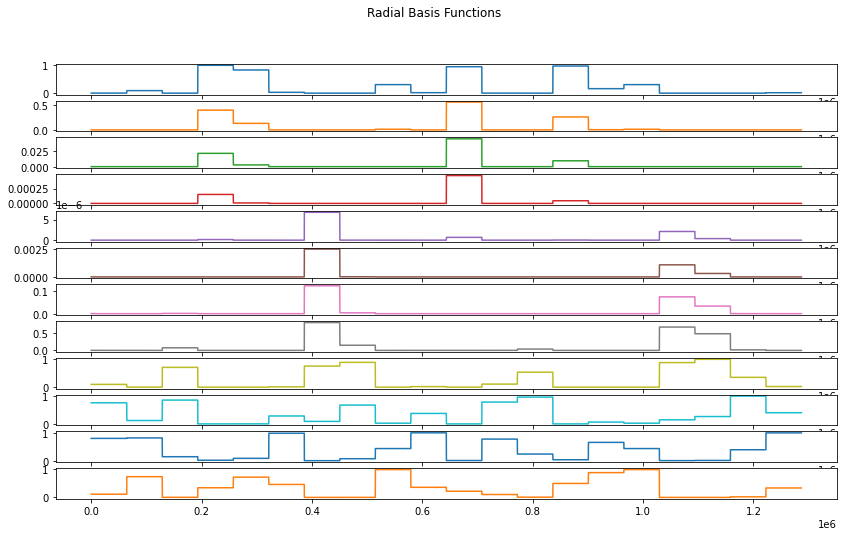

In [32]:
tickets_dates_tranformed.plot(subplots=True, figsize=(14, 8),
     	sharex=True, title="Radial Basis Functions",
     	legend=False);

In [27]:
tickets_dates.head()

,event_date,day_of_year
0,2021-10-17,290
1,2021-10-17,290
2,2021-10-17,290
3,2021-10-17,290
4,2021-10-17,290


In [11]:
# generate the DataFrame with dates
range_of_dates = pd.date_range(start="2017-01-01",
                           	end="2020-12-30")
X = pd.DataFrame(index=range_of_dates)

# create a sequence of day numbers
X["day_nr"] = range(len(X))
X["day_of_year"] = X.index.day_of_year


In [12]:
X

,day_nr,day_of_year
2017-01-01,0,1
2017-01-02,1,2
2017-01-03,2,3
2017-01-04,3,4
2017-01-05,4,5
...,...,...
2020-12-26,1455,361
2020-12-27,1456,362
2020-12-28,1457,363
2020-12-29,1458,364


In [38]:
tickets.Term.unique()

array([nan,  3.,  5.,  2.,  1.,  4.])

In [18]:
print(type(tickets["add_datetime"][0]))

<class 'str'>


In [22]:
tickets["add_datetime"][0].split()[0]

'2021-03-31'

In [35]:
### Ticket added?

def ticket_added(ticket_date_add):
    if (ticket_date_add == 'NaN'):
        return "No"
    else:
        return "Yes"
        
tickets["ticket_added"] = tickets["add_datetime"].apply(ticket_added)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114


/var/folders/mh/9fr225sj6bd0qgb1553s86dw0000gn/T/ipykernel_18259/2807151035.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tickets["add_time"][i] = tickets["add_datetime"][i].split()[1]


AttributeError: 'float' object has no attribute 'split'

In [6]:
tickets["add_date"] = [d.date() for d in tickets["add_datetime"]]
tickets["add_time"] = [d.time() for d in tickets["add_datetime"]]

AttributeError: 'str' object has no attribute 'date'

In [34]:
tickets.iloc[114,:]

acct_id                           190
acct_type_desc                    NaN
event_name                   CLT21HOU
event_date                 2021-10-17
plan_event_name                   NaN
comp_name                         NaN
section_name                      101
row_name                           15
SeatNum                            13
price_code                       FS03
PC1                                 F
Price                           111.0
paid                              NaN
add_datetime                      NaN
class_name                  DIST-OPEN
status                          AVAIL
Sales_Source                      NaN
isHost                              0
SeatType                           GA
TicketClass                  Manifest
Start Year                        NaN
LastYear                          NaN
Term                              NaN
TicketType             SingleGm Avail
SeatUniqueID                101-15-13
Season                           2021
ClubExpYear 

In [ ]:
tickets.head()

In [51]:
tickets['paid'].unique()

tickets[['paid']] = tickets[['paid']].replace(np.nan, 'unknown')


array(['Y', nan, 'N', 'P'], dtype=object)

In [52]:
tickets['acct_type_desc'].unique()
tickets[['acct_type_desc']] = tickets[['acct_type_desc']].replace(np.nan, 'acct_desc_unknown')


array(['Season', 'Employee', 'Club', nan, 'Sponsor', 'Comp', 'House',
       'Personal', 'Suite', 'Group', 'Opponents', 'Player', 'SG Suite',
       'Single Game', 'Huntington 2015', 'Kids Club', 'Huntington 2018',
       'Group NEW', 'Huntington 2016', 'Huntington 2017',
       'Huntington 2014', 'Huntington 2019', 'Hold Account', 'Hold',
       'NONRENEWAL', 'Huntington 2021', 'Huntington', 'Premium',
       'Window Account', 'IU 2022', 'Huntington 2022'], dtype=object)

In [53]:
tickets['comp_name'].unique()
tickets[['comp_name']] = tickets[['comp_name']].replace(np.nan, 'comp_name_unknown')



array(['Not Comp', 'Front Office/Club Staff', nan,
       'VIP/Local Dignitaries', 'Coaches & Trainers',
       'Charity/Community Relations', 'Game Entertainment',
       'Youth Football', 'Promotions', 'Stadium Personnel', 'Players',
       'Sponsors', 'League Employees', 'Miscellaneous', 'Covid-19',
       'Media', 'Sales Prospecting', 'Game Official and Chain Crew',
       'Customer Service', 'Club Alumni', 'Military', 'Ownership Guests',
       'archiveBusiness'], dtype=object)

In [56]:
tickets['plan_event_name'].unique()
tickets[['plan_event_name']] = tickets[['plan_event_name']].replace(np.nan, 'plan_event_name_unknown')


array(['21FS', nan, '21FS9', '22FS', '22FS8', '22FS9', '22MPACK',
       '22MPACK2'], dtype=object)

In [59]:
tickets['Tenure'].unique()

array([25., 20.,  4., 32.,  7., 22., 38., 30., 24., 26., 18., 28., 23.,
       11., 34., 29., 27.,  2.,  3., 19., 17., 31., 36., nan, 15., 21.,
       16., 35., 12., 10., 37.,  8., 13.,  1., 14.,  9., 33.,  5.,  6.,
        0.])

In [62]:
tickets['ClubExpYear'].unique()
tickets[['ClubExpYear']] = tickets[['ClubExpYear']].replace(np.nan, 'exp_year_unknown')


array([  nan, 2022., 2021., 2023., 2024.])

In [71]:
tickets['PC1'].unique()

array(['F', 'Y', 'G', 'D', 'B', 'W', 'A', '8', '5', 'C', '6', 'I', '9',
       '7', 'J', 'L', 'N', 'Z', 'E', 'S', 'Q', 'M', 'K', 'H', 'U', 'V',
       'T', 'R', 'P', 'O', 'X'], dtype=object)

In [72]:
tickets['Tenure'].unique()

array([25., 20.,  4., 32.,  7., 22., 38., 30., 24., 26., 18., 28., 23.,
       11., 34., 29., 27.,  2.,  3., 19., 17., 31., 36.,  0., 15., 21.,
       16., 35., 12., 10., 37.,  8., 13.,  1., 14.,  9., 33.,  5.,  6.])

In [14]:
tickets['Resold'].unique()

array([0., 1.])

In [76]:
tickets.head()

,acct_type_desc,event_name,plan_event_name,comp_name,section_name,row_name,SeatNum,price_code,PC1,Price,...,event_date_3,event_date_4,event_date_5,event_date_6,event_date_7,event_date_8,event_date_9,event_date_10,event_date_11,ticket_added
0,Season,CLT21HOU,21FS,Not Comp,101,10,1,FR,F,111.0,...,9.851605e-14,5.382962e-14,1.252646e-09,0.000004,0.001681,0.096988,0.757125,0.799889,0.114368,Yes
1,Season,CLT21HOU,21FS,Not Comp,101,10,10,FR,F,111.0,...,9.851605e-14,5.382962e-14,1.252646e-09,0.000004,0.001681,0.096988,0.757125,0.799889,0.114368,Yes
2,Season,CLT21HOU,21FS,Not Comp,101,10,11,FR,F,111.0,...,9.851605e-14,5.382962e-14,1.252646e-09,0.000004,0.001681,0.096988,0.757125,0.799889,0.114368,Yes
3,Season,CLT21HOU,21FS,Not Comp,101,10,12,FR,F,111.0,...,9.851605e-14,5.382962e-14,1.252646e-09,0.000004,0.001681,0.096988,0.757125,0.799889,0.114368,Yes
4,Season,CLT21HOU,21FS,Not Comp,101,10,13,FR,F,111.0,...,9.851605e-14,5.382962e-14,1.252646e-09,0.000004,0.001681,0.096988,0.757125,0.799889,0.114368,Yes


In [73]:
tickets.isnull().sum()

acct_type_desc     0
event_name         0
plan_event_name    0
comp_name          0
section_name       0
row_name           0
SeatNum            0
price_code         0
PC1                0
Price              0
paid               0
class_name         0
status             0
Sales_Source       0
isHost             0
SeatType           0
TicketClass        0
Term               0
TicketType         0
SeatUniqueID       0
Season             0
ClubExpYear        0
Tenure             0
UniqueID           0
isAttended         0
Resold             0
isSTM              0
opponent           0
event_date_0       0
event_date_1       0
event_date_2       0
event_date_3       0
event_date_4       0
event_date_5       0
event_date_6       0
event_date_7       0
event_date_8       0
event_date_9       0
event_date_10      0
event_date_11      0
ticket_added       0
dtype: int64

In [5]:
tickets['event_name'].unique()

array(['CLT21HOU', 'CLT21JAX', 'CLT21LAR', 'CLT21LV', 'CLT21NE',
       'CLT21NYJ', 'CLT21PRE', 'CLT21SEA', 'CLT21TB', 'CLT21TEN',
       'CLT22HOU', 'CLT22JAX', 'CLT22KC', 'CLT22LAC', 'CLT22PHI',
       'CLT22PIT', 'CLT22PR1', 'CLT22PR2', 'CLT22TEN', 'CLT22WAS'],
      dtype=object)

In [6]:
tickets['event_date'].unique()

array(['2021-10-17', '2021-11-14', '2021-09-19', '2022-01-02',
       '2021-12-18', '2021-11-04', '2021-08-15', '2021-09-12',
       '2021-11-28', '2021-10-31', '2023-01-08', '2022-10-16',
       '2022-09-25', '2022-12-26', '2022-11-20', '2022-11-28',
       '2022-08-20', '2022-08-27', '2022-10-02', '2022-10-30'],
      dtype=object)

In [16]:
extra_predictors['Date']

'8/15/21'

In [ ]:
extra_predictors['Date'] = pd.to_datetime(extra_predictors['Date'], infer_datetime_format=True)


In [38]:
extra_predictors = pd.read_csv("../predictors_extra.csv")

In [44]:
extra_predictors['Date'] = pd.to_datetime(extra_predictors['Date'], infer_datetime_format=True)


In [47]:
def format_date(datetime):
    return datetime.strftime("%Y-%m-%d")

extra_predictors['Date'] = extra_predictors['Date'].apply(format_date)


extra_predictors['Date'][0].strftime("%Y-%m-%d")

'2021-08-15'

In [45]:
extra_predictors['Date'][0].strftime("%a")

'Sun'

In [30]:
def get_the_day2(dateyear):
    date = datetime.strptime(dateyear, "%Y-%m-%d")
    return date.timetuple().tm_yday

In [37]:
def split_time(date):
  temp_var = date.strftime("%Y-%m-%d, %H:%M:%S")
  return temp_var.split(",")[0]


extra_predictors['Date'].apply(split_time)

AttributeError: 'str' object has no attribute 'strftime'

In [21]:
days = []
for date in dates:
    dt = datetime.strptime(date, "%m/%d/%Y")
    days.append(dt.strftime("%a"))

date_day_dict = dict(zip(dates, days))
print(date_day_dict)


ValueError: time data '8/15/21' does not match format '%m/%d/%Y'

In [ ]:
df = pd.DataFrame({'date': dates})
df.date = pd.to_datetime(df.date)
df['day'] = df.date.dt.day_name()
print(df)

In [ ]:
def split_time(date):
  temp_var = date.strftime("%Y-%m-%d, %H:%M:%S")
  return temp_var.split(",")[0]

df['date_str'] = df['date'].apply(split_time)

In [27]:
extra_predictors['Date']

0    2021-08-15
1    2021-09-12
2    2021-09-19
3    2021-10-17
4    2021-10-31
5    2021-11-04
6    2021-11-14
7    2021-11-28
8    2021-12-18
9    2022-01-02
10   2022-08-20
11   2022-08-27
12   2022-09-25
13   2022-10-02
14   2022-10-16
15   2022-10-30
16   2022-11-20
17   2022-11-28
18   2022-12-26
19   2023-01-08
Name: Date, dtype: datetime64[ns]

In [26]:
extra_predictors['Date'].apply(get_the_day2)

TypeError: strptime() argument 1 must be str, not Timestamp

In [ ]:
dt.strftime("%a")




In [23]:
one_hot_encoded_extra_pd.head()

,Reich,Saturday,Cloudy,Sunny,N,Y,Closed,Open,Yes,No,...,Saturday,Sunday,Sunday,Thursday,No,Yes,No,Yes,No,Yes
0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
1,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
2,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
3,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
4,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0


In [29]:
tickets_bare.columns

Index(['event_name', 'Price', 'Term', 'SeatUniqueID', 'Tenure', 'UniqueID',
       'isAttended', 'event_date_0', 'event_date_1', 'event_date_2',
       'event_date_3', 'event_date_4', 'event_date_5', 'event_date_6',
       'event_date_7', 'event_date_8', 'event_date_9', 'event_date_10',
       'event_date_11', 'Reich', 'Saturday', 'Cloudy', 'Sunny', 'N', 'Y',
       'Closed', 'Open', 'Yes', 'No', 'Yes', 'No', 'Yes', 'Monday', 'Saturday',
       'Sunday', 'Sunday ', 'Thursday', 'No', 'Yes', 'No', 'Yes', 'No', 'Yes'],
      dtype='object')

In [8]:
tickets['event_name'].unique()

array(['CLT21HOU', 'CLT21JAX', 'CLT21LAR', 'CLT21NE', 'CLT21NYJ',
       'CLT21PRE', 'CLT21SEA', 'CLT21TB', 'CLT21TEN', 'CLT22JAX',
       'CLT22KC', 'CLT22LAC', 'CLT22PHI', 'CLT22PIT', 'CLT22PR1',
       'CLT22PR2', 'CLT22TEN', 'CLT22WAS', 'CLT21LV', 'CLT22HOU'],
      dtype=object)

In [6]:
tickets_test['event_name'].unique()

array(['CLT21LV', 'CLT22HOU'], dtype=object)

In [4]:
tickets.head()

,acct_id,acct_type_desc,event_name,event_date,plan_event_name,comp_name,section_name,row_name,SeatNum,price_code,...,SeatUniqueID,Season,ClubExpYear,Tenure,UniqueID,isAttended,Resold,ResalePrice,ResaleDate,isSTM
0,117948790,Season,CLT21HOU,2021-10-17,21FS,Not Comp,101,10,1,FR,...,101-10-1,2021,NaN,25.0,CLT21HOU-101-10-1,Yes,NaN,NaN,NaN,NaN
1,126665090,Season,CLT21HOU,2021-10-17,21FS,Not Comp,101,10,10,FR,...,101-10-10,2021,NaN,20.0,CLT21HOU-101-10-10,No,NaN,NaN,NaN,NaN
2,126665090,Season,CLT21HOU,2021-10-17,21FS,Not Comp,101,10,11,FR,...,101-10-11,2021,NaN,20.0,CLT21HOU-101-10-11,No,NaN,NaN,NaN,NaN
3,1489599590,Season,CLT21HOU,2021-10-17,21FS,Not Comp,101,10,12,FR,...,101-10-12,2021,NaN,4.0,CLT21HOU-101-10-12,Yes,NaN,NaN,NaN,NaN
4,115101990,Season,CLT21HOU,2021-10-17,21FS,Not Comp,101,10,13,FR,...,101-10-13,2021,NaN,32.0,CLT21HOU-101-10-13,No,NaN,NaN,NaN,NaN


In [5]:
tickets_test.head()

,acct_id,acct_type_desc,event_name,event_date,plan_event_name,comp_name,section_name,row_name,SeatNum,price_code,...,TicketType,SeatUniqueID,Season,ClubExpYear,Tenure,UniqueID,Resold,ResalePrice,ResaleDate,isSTM
0,117948790,Season,CLT21LV,1/2/22,21FS,Not Comp,101,10,1,FR,...,Renewal,101-10-1,2021,NaN,25.0,CLT21LV-101-10-1,NaN,NaN,NaN,NaN
1,126665090,Season,CLT21LV,1/2/22,21FS,Not Comp,101,10,10,FR,...,Renewal,101-10-10,2021,NaN,20.0,CLT21LV-101-10-10,NaN,NaN,NaN,NaN
2,126665090,Season,CLT21LV,1/2/22,21FS,Not Comp,101,10,11,FR,...,Renewal,101-10-11,2021,NaN,20.0,CLT21LV-101-10-11,NaN,NaN,NaN,NaN
3,1489599590,Season,CLT21LV,1/2/22,21FS,Not Comp,101,10,12,FR,...,Renewal,101-10-12,2021,NaN,4.0,CLT21LV-101-10-12,NaN,NaN,NaN,NaN
4,115101990,Season,CLT21LV,1/2/22,21FS,Not Comp,101,10,13,FR,...,Renewal,101-10-13,2021,NaN,32.0,CLT21LV-101-10-13,NaN,NaN,NaN,NaN


In [16]:
def to_the_proper_date(bad_date):
    # Converting to datetime object, then converting to string with the format I want
    return datetime.strptime(bad_date, '%m/%d/%y').strftime("%Y-%m-%d")


tickets_test['event_date'] =tickets_test['event_date'].apply(to_the_proper_date)

In [17]:
type(tickets['event_date'][1])

str

In [18]:
tickets_test['event_date']

0         2022-01-02
1         2022-01-02
2         2022-01-02
3         2022-01-02
4         2022-01-02
             ...    
128683    2023-01-08
128684    2023-01-08
128685    2023-01-08
128686    2023-01-08
128687    2023-01-08
Name: event_date, Length: 128688, dtype: object

In [3]:
X_train = pd.read_csv("../PCA_data/X_train.csv")
X_train.head()

,Unnamed: 0,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,UniqueID
0,0,13.848857,-0.884872,-1.365181,-0.756102,-1.104887,-0.306085,-0.276926,0.337090,-0.928292,0.076208,-0.057707,NaN
1,1,8.855454,-0.758633,-1.356332,-0.729150,-1.143661,-0.497751,-0.344749,0.374753,-0.930381,0.034083,-0.033193,NaN
2,2,8.855385,-0.758939,-1.356411,-0.729342,-1.143519,-0.497102,-0.344503,0.374662,-0.930389,0.034083,-0.033239,NaN
3,3,-7.121194,-0.354696,-1.326716,-0.640603,-1.269151,-1.115287,-0.563177,0.505954,-0.939517,-0.123085,0.062736,NaN
4,4,20.837786,-1.062048,-1.378777,-0.796067,-1.049037,-0.031981,-0.179756,0.275356,-0.923093,0.154704,-0.106962,NaN


In [4]:
X_test = pd.read_csv("../PCA_data/X_test.csv")
X_test.head()

,Unnamed: 0,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,UniqueID
0,0,13.855778,-0.584738,0.503755,-1.731565,0.277595,-0.755610,-0.046677,0.210862,-0.062143,0.195676,0.481460,CLT21HOU-101-10-1
1,1,8.862376,-0.458499,0.512604,-1.704613,0.238821,-0.947275,-0.114501,0.248525,-0.064232,0.153551,0.505973,CLT21HOU-101-10-10
2,2,8.862306,-0.458805,0.512525,-1.704805,0.238964,-0.946626,-0.114254,0.248434,-0.064241,0.153551,0.505928,CLT21HOU-101-10-11
3,3,-7.114272,-0.054562,0.542220,-1.616066,0.113331,-1.564812,-0.332929,0.379726,-0.073368,-0.003618,0.601903,CLT21HOU-101-10-12
4,4,20.844707,-0.761914,0.490159,-1.771529,0.333445,-0.481506,0.050492,0.149127,-0.056944,0.274171,0.432205,CLT21HOU-101-10-13


In [37]:
y_train = pd.read_csv("../PCA_data/y_train2.csv")
y_test = pd.read_csv("../PCA_data/y_test2.csv")
X_train = pd.read_csv("../PCA_data/X_train.csv")
X_test = pd.read_csv("../PCA_data/X_test.csv")

FileNotFoundError: [Errno 2] No such file or directory: '../PCA_data/y_train2.csv'

In [4]:
test_labels =pd.read_csv("../PCA_data/test_labels.csv")
train_labels =pd.read_csv("../PCA_data/train_label.csv")

In [5]:
pd.merge(y_train, train_labels, on = ['UniqueID'])

,Unnamed: 0_x,isAttended,UniqueID,Unnamed: 0_y,event_name
0,0,1,CLT21HOU-101-10-1,0,CLT21HOU
1,1,0,CLT21HOU-101-10-10,1,CLT21HOU
2,2,0,CLT21HOU-101-10-11,2,CLT21HOU
3,3,1,CLT21HOU-101-10-12,3,CLT21HOU
4,4,0,CLT21HOU-101-10-13,4,CLT21HOU
...,...,...,...,...,...
1158223,1158223,0,CLT22WAS-646-9-5,1158223,CLT22WAS
1158224,1158224,1,CLT22WAS-646-9-6,1158224,CLT22WAS
1158225,1158225,1,CLT22WAS-646-9-7,1158225,CLT22WAS
1158226,1158226,1,CLT22WAS-646-9-8,1158226,CLT22WAS


In [6]:
pd.merge(y_test, test_labels, on = ['UniqueID'])

,Unnamed: 0_x,UniqueID,Unnamed: 0_y,event_name
0,1158228,CLT21LV-101-10-1,1158228,CLT21LV
1,1158229,CLT21LV-101-10-10,1158229,CLT21LV
2,1158230,CLT21LV-101-10-11,1158230,CLT21LV
3,1158231,CLT21LV-101-10-12,1158231,CLT21LV
4,1158232,CLT21LV-101-10-13,1158232,CLT21LV
...,...,...,...,...
128683,1286911,CLT22HOU-646-9-5,1286911,CLT22HOU
128684,1286912,CLT22HOU-646-9-6,1286912,CLT22HOU
128685,1286913,CLT22HOU-646-9-7,1286913,CLT22HOU
128686,1286914,CLT22HOU-646-9-8,1286914,CLT22HOU


In [7]:
pd.merge(X_train, train_labels, on = ['UniqueID'])

,Unnamed: 0_x,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,UniqueID,Unnamed: 0_y,event_name
0,0,13.848857,-0.884872,-1.365181,-0.756102,-1.104887,-0.306085,-0.276926,0.337090,-0.928292,0.076208,-0.057707,CLT21HOU-101-10-1,0,CLT21HOU
1,1,8.855454,-0.758633,-1.356332,-0.729150,-1.143661,-0.497751,-0.344749,0.374753,-0.930381,0.034083,-0.033193,CLT21HOU-101-10-10,1,CLT21HOU
2,2,8.855385,-0.758939,-1.356411,-0.729342,-1.143519,-0.497102,-0.344503,0.374662,-0.930389,0.034083,-0.033239,CLT21HOU-101-10-11,2,CLT21HOU
3,3,-7.121194,-0.354696,-1.326716,-0.640603,-1.269151,-1.115287,-0.563177,0.505954,-0.939517,-0.123085,0.062736,CLT21HOU-101-10-12,3,CLT21HOU
4,4,20.837786,-1.062048,-1.378777,-0.796067,-1.049037,-0.031981,-0.179756,0.275356,-0.923093,0.154704,-0.106962,CLT21HOU-101-10-13,4,CLT21HOU
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1158223,1158223,-11.210219,-0.401037,1.845350,-0.232315,-0.943758,-0.506672,0.794084,-1.234214,-0.394806,0.081161,0.635440,CLT22WAS-646-9-5,1158223,CLT22WAS
1158224,1158224,-11.208634,-0.395049,1.807058,-0.258607,-0.927251,-0.493749,0.793863,-1.121376,-0.383457,-0.029187,0.716684,CLT22WAS-646-9-6,1158224,CLT22WAS
1158225,1158225,-3.236418,-0.324480,1.299075,-1.014449,-0.360792,0.797323,1.019688,-1.229317,-0.154304,0.469403,0.436836,CLT22WAS-646-9-7,1158225,CLT22WAS
1158226,1158226,-3.236421,-0.324747,1.299130,-1.014464,-0.360899,0.796867,1.019509,-1.229293,-0.154340,0.469351,0.436787,CLT22WAS-646-9-8,1158226,CLT22WAS


In [8]:
pd.merge(X_test, test_labels, on = ['UniqueID'])

,Unnamed: 0_x,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,UniqueID,Unnamed: 0_y,event_name


In [46]:
test_labels.head()

,Unnamed: 0,event_name,UniqueID
0,1158228,CLT21LV,CLT21LV-101-10-1
1,1158229,CLT21LV,CLT21LV-101-10-10
2,1158230,CLT21LV,CLT21LV-101-10-11
3,1158231,CLT21LV,CLT21LV-101-10-12
4,1158232,CLT21LV,CLT21LV-101-10-13


In [47]:
train_labels.head()

,Unnamed: 0,event_name,UniqueID
0,0,CLT21HOU,CLT21HOU-101-10-1
1,1,CLT21HOU,CLT21HOU-101-10-10
2,2,CLT21HOU,CLT21HOU-101-10-11
3,3,CLT21HOU,CLT21HOU-101-10-12
4,4,CLT21HOU,CLT21HOU-101-10-13


In [40]:
y_train.head()

,Unnamed: 0,isAttended,UniqueID
0,0,1,CLT21HOU-101-10-1
1,1,0,CLT21HOU-101-10-10
2,2,0,CLT21HOU-101-10-11
3,3,1,CLT21HOU-101-10-12
4,4,0,CLT21HOU-101-10-13


In [68]:
y_test.head()

,Unnamed: 0,y_train,UniqueID
0,0,NaN,CLT21HOU-101-10-1
1,1,NaN,CLT21HOU-101-10-10
2,2,NaN,CLT21HOU-101-10-11
3,3,NaN,CLT21HOU-101-10-12
4,4,NaN,CLT21HOU-101-10-13


In [41]:
X_test.head()

,Unnamed: 0,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,UniqueID
0,0,13.855778,-0.584738,0.503755,-1.731565,0.277595,-0.755610,-0.046677,0.210862,-0.062143,0.195676,0.481460,CLT21HOU-101-10-1
1,1,8.862376,-0.458499,0.512604,-1.704613,0.238821,-0.947275,-0.114501,0.248525,-0.064232,0.153551,0.505973,CLT21HOU-101-10-10
2,2,8.862306,-0.458805,0.512525,-1.704805,0.238964,-0.946626,-0.114254,0.248434,-0.064241,0.153551,0.505928,CLT21HOU-101-10-11
3,3,-7.114272,-0.054562,0.542220,-1.616066,0.113331,-1.564812,-0.332929,0.379726,-0.073368,-0.003618,0.601903,CLT21HOU-101-10-12
4,4,20.844707,-0.761914,0.490159,-1.771529,0.333445,-0.481506,0.050492,0.149127,-0.056944,0.274171,0.432205,CLT21HOU-101-10-13


In [42]:
X_train.head()

,Unnamed: 0,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,UniqueID
0,0,13.848857,-0.884872,-1.365181,-0.756102,-1.104887,-0.306085,-0.276926,0.337090,-0.928292,0.076208,-0.057707,CLT21HOU-101-10-1
1,1,8.855454,-0.758633,-1.356332,-0.729150,-1.143661,-0.497751,-0.344749,0.374753,-0.930381,0.034083,-0.033193,CLT21HOU-101-10-10
2,2,8.855385,-0.758939,-1.356411,-0.729342,-1.143519,-0.497102,-0.344503,0.374662,-0.930389,0.034083,-0.033239,CLT21HOU-101-10-11
3,3,-7.121194,-0.354696,-1.326716,-0.640603,-1.269151,-1.115287,-0.563177,0.505954,-0.939517,-0.123085,0.062736,CLT21HOU-101-10-12
4,4,20.837786,-1.062048,-1.378777,-0.796067,-1.049037,-0.031981,-0.179756,0.275356,-0.923093,0.154704,-0.106962,CLT21HOU-101-10-13


In [41]:
test_UniqueID

,UniqueID
1158228,CLT21LV-101-10-1
1158229,CLT21LV-101-10-10
1158230,CLT21LV-101-10-11
1158231,CLT21LV-101-10-12
1158232,CLT21LV-101-10-13
...,...
1286911,CLT22HOU-646-9-5
1286912,CLT22HOU-646-9-6
1286913,CLT22HOU-646-9-7
1286914,CLT22HOU-646-9-8


In [34]:
train['isAttended'].unique()

array([1, 0])

In [33]:
tickets['isAttended'].unique()

array([1, 0, 2])

In [3]:
y_train = pd.read_csv("../PCA_data/y_train2.csv")
y_test = pd.read_csv("../PCA_data/y_test2.csv")
X_train = pd.read_csv("../PCA_data/X_train.csv")
X_test = pd.read_csv("../PCA_data/X_test.csv")

In [4]:
test_labels =pd.read_csv("../PCA_data/test_labels.csv")
train_labels =pd.read_csv("../PCA_data/train_label.csv")

In [5]:
y_train.head()

,Unnamed: 0,isAttended,UniqueID,event_name
0,0,1,CLT21HOU-101-10-1,CLT21HOU
1,1,0,CLT21HOU-101-10-10,CLT21HOU
2,2,0,CLT21HOU-101-10-11,CLT21HOU
3,3,1,CLT21HOU-101-10-12,CLT21HOU
4,4,0,CLT21HOU-101-10-13,CLT21HOU


In [6]:
X_train.head()

,Unnamed: 0,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,UniqueID
0,0,13.848857,-0.884872,-1.365181,-0.756102,-1.104887,-0.306085,-0.276926,0.337090,-0.928292,0.076208,-0.057707,CLT21HOU-101-10-1
1,1,8.855454,-0.758633,-1.356332,-0.729150,-1.143661,-0.497751,-0.344749,0.374753,-0.930381,0.034083,-0.033193,CLT21HOU-101-10-10
2,2,8.855385,-0.758939,-1.356411,-0.729342,-1.143519,-0.497102,-0.344503,0.374662,-0.930389,0.034083,-0.033239,CLT21HOU-101-10-11
3,3,-7.121194,-0.354696,-1.326716,-0.640603,-1.269151,-1.115287,-0.563177,0.505954,-0.939517,-0.123085,0.062736,CLT21HOU-101-10-12
4,4,20.837786,-1.062048,-1.378777,-0.796067,-1.049037,-0.031981,-0.179756,0.275356,-0.923093,0.154704,-0.106962,CLT21HOU-101-10-13


In [10]:
X_test.head()

,Unnamed: 0,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,UniqueID
0,0,13.855778,-0.584738,0.503755,-1.731565,0.277595,-0.755610,-0.046677,0.210862,-0.062143,0.195676,0.481460,CLT21LV-101-10-1
1,1,8.862376,-0.458499,0.512604,-1.704613,0.238821,-0.947275,-0.114501,0.248525,-0.064232,0.153551,0.505973,CLT21LV-101-10-10
2,2,8.862306,-0.458805,0.512525,-1.704805,0.238964,-0.946626,-0.114254,0.248434,-0.064241,0.153551,0.505928,CLT21LV-101-10-11
3,3,-7.114272,-0.054562,0.542220,-1.616066,0.113331,-1.564812,-0.332929,0.379726,-0.073368,-0.003618,0.601903,CLT21LV-101-10-12
4,4,20.844707,-0.761914,0.490159,-1.771529,0.333445,-0.481506,0.050492,0.149127,-0.056944,0.274171,0.432205,CLT21LV-101-10-13


In [8]:
test_labels.head()

,Unnamed: 0.1,Unnamed: 0,event_name,UniqueID
0,0,1158228,CLT21LV,CLT21LV-101-10-1
1,1,1158229,CLT21LV,CLT21LV-101-10-10
2,2,1158230,CLT21LV,CLT21LV-101-10-11
3,3,1158231,CLT21LV,CLT21LV-101-10-12
4,4,1158232,CLT21LV,CLT21LV-101-10-13


In [9]:
X_test['UniqueID'] = test_labels['UniqueID']

In [11]:
X_test.to_csv("../PCA_data/X_test_official.csv")
X_train.to_csv("../PCA_data/X_train_official.csv")
y_train.to_csv("../PCA_data/y_train_official.csv")
y_test.to_csv("../PCA_data/y_test_official.csv")

# Making the verification test split

In [12]:
X_test = pd.read_csv("../PCA_data/X_test_official.csv")
X_train = pd.read_csv("../PCA_data/X_train_official.csv")
y_train= pd.read_csv("../PCA_data/y_train_official.csv")
y_test = pd.read_csv("../PCA_data/y_test_official.csv")

test_labels =pd.read_csv("../PCA_data/test_labels.csv")
train_labels =pd.read_csv("../PCA_data/train_label.csv")

In [13]:
X_train.head()

,Unnamed: 0.1,Unnamed: 0,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,UniqueID
0,0,0,13.848857,-0.884872,-1.365181,-0.756102,-1.104887,-0.306085,-0.276926,0.337090,-0.928292,0.076208,-0.057707,CLT21HOU-101-10-1
1,1,1,8.855454,-0.758633,-1.356332,-0.729150,-1.143661,-0.497751,-0.344749,0.374753,-0.930381,0.034083,-0.033193,CLT21HOU-101-10-10
2,2,2,8.855385,-0.758939,-1.356411,-0.729342,-1.143519,-0.497102,-0.344503,0.374662,-0.930389,0.034083,-0.033239,CLT21HOU-101-10-11
3,3,3,-7.121194,-0.354696,-1.326716,-0.640603,-1.269151,-1.115287,-0.563177,0.505954,-0.939517,-0.123085,0.062736,CLT21HOU-101-10-12
4,4,4,20.837786,-1.062048,-1.378777,-0.796067,-1.049037,-0.031981,-0.179756,0.275356,-0.923093,0.154704,-0.106962,CLT21HOU-101-10-13


In [17]:
y_train.head()

,Unnamed: 0.1,Unnamed: 0,isAttended,UniqueID,event_name
0,0,0,1,CLT21HOU-101-10-1,CLT21HOU
1,1,1,0,CLT21HOU-101-10-10,CLT21HOU
2,2,2,0,CLT21HOU-101-10-11,CLT21HOU
3,3,3,1,CLT21HOU-101-10-12,CLT21HOU
4,4,4,0,CLT21HOU-101-10-13,CLT21HOU


In [14]:
train_labels.head()

,Unnamed: 0.1,Unnamed: 0,event_name,UniqueID
0,0,0,CLT21HOU,CLT21HOU-101-10-1
1,1,1,CLT21HOU,CLT21HOU-101-10-10
2,2,2,CLT21HOU,CLT21HOU-101-10-11
3,3,3,CLT21HOU,CLT21HOU-101-10-12
4,4,4,CLT21HOU,CLT21HOU-101-10-13


In [15]:
X_train = X_train.drop(labels= ["Unnamed: 0.1","Unnamed: 0"], axis = 1)
train_labels = train_labels.drop(labels= ["Unnamed: 0.1","Unnamed: 0"], axis = 1)

In [18]:
y_train = y_train.drop(labels= ["Unnamed: 0.1","Unnamed: 0"], axis = 1)

In [22]:
y_train.head()

,isAttended,UniqueID,event_name
0,1,CLT21HOU-101-10-1,CLT21HOU
1,0,CLT21HOU-101-10-10,CLT21HOU
2,0,CLT21HOU-101-10-11,CLT21HOU
3,1,CLT21HOU-101-10-12,CLT21HOU
4,0,CLT21HOU-101-10-13,CLT21HOU


In [16]:
full_X_train_ver = pd.merge(X_train,train_labels, on = ['UniqueID'])
full_X_train_ver.head()

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,UniqueID,event_name
0,13.848857,-0.884872,-1.365181,-0.756102,-1.104887,-0.306085,-0.276926,0.337090,-0.928292,0.076208,-0.057707,CLT21HOU-101-10-1,CLT21HOU
1,8.855454,-0.758633,-1.356332,-0.729150,-1.143661,-0.497751,-0.344749,0.374753,-0.930381,0.034083,-0.033193,CLT21HOU-101-10-10,CLT21HOU
2,8.855385,-0.758939,-1.356411,-0.729342,-1.143519,-0.497102,-0.344503,0.374662,-0.930389,0.034083,-0.033239,CLT21HOU-101-10-11,CLT21HOU
3,-7.121194,-0.354696,-1.326716,-0.640603,-1.269151,-1.115287,-0.563177,0.505954,-0.939517,-0.123085,0.062736,CLT21HOU-101-10-12,CLT21HOU
4,20.837786,-1.062048,-1.378777,-0.796067,-1.049037,-0.031981,-0.179756,0.275356,-0.923093,0.154704,-0.106962,CLT21HOU-101-10-13,CLT21HOU


In [19]:
full_y_train_ver = pd.merge(y_train, train_labels, on = ['UniqueID'])
full_y_train_ver.head()

,isAttended,UniqueID,event_name_x,event_name_y
0,1,CLT21HOU-101-10-1,CLT21HOU,CLT21HOU
1,0,CLT21HOU-101-10-10,CLT21HOU,CLT21HOU
2,0,CLT21HOU-101-10-11,CLT21HOU,CLT21HOU
3,1,CLT21HOU-101-10-12,CLT21HOU,CLT21HOU
4,0,CLT21HOU-101-10-13,CLT21HOU,CLT21HOU


In [20]:
X_test.head()

,Unnamed: 0.1,Unnamed: 0,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,UniqueID
0,0,0,13.855778,-0.584738,0.503755,-1.731565,0.277595,-0.755610,-0.046677,0.210862,-0.062143,0.195676,0.481460,CLT21LV-101-10-1
1,1,1,8.862376,-0.458499,0.512604,-1.704613,0.238821,-0.947275,-0.114501,0.248525,-0.064232,0.153551,0.505973,CLT21LV-101-10-10
2,2,2,8.862306,-0.458805,0.512525,-1.704805,0.238964,-0.946626,-0.114254,0.248434,-0.064241,0.153551,0.505928,CLT21LV-101-10-11
3,3,3,-7.114272,-0.054562,0.542220,-1.616066,0.113331,-1.564812,-0.332929,0.379726,-0.073368,-0.003618,0.601903,CLT21LV-101-10-12
4,4,4,20.844707,-0.761914,0.490159,-1.771529,0.333445,-0.481506,0.050492,0.149127,-0.056944,0.274171,0.432205,CLT21LV-101-10-13


In [21]:
y_test.head()

,Unnamed: 0.1,Unnamed: 0,isAttended,UniqueID,event_name
0,0,1158228,2,CLT21LV-101-10-1,CLT21LV
1,1,1158229,2,CLT21LV-101-10-10,CLT21LV
2,2,1158230,2,CLT21LV-101-10-11,CLT21LV
3,3,1158231,2,CLT21LV-101-10-12,CLT21LV
4,4,1158232,2,CLT21LV-101-10-13,CLT21LV
